<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Exploratory Data Analysis

There are several things you can do with Pipeline output, including analyzing forward returns with Alphalens or feeding the results to a Zipline strategy. However, a useful first step in most cases is to explore the data to get a basic sense of the data's distribution and characteristics. This can often highlight ways that you must massage the data or tweak your computations to achieve the desired results.


## Exploring the Profitability Factor

In an earlier lesson, we defined a factor for operating margin, defined as operating income divided by revenue. Operating margin is a measure of profitability. If a company has an operating margin of 10% (0.1), this means that for every dollar of revenue, the company earns 10 cents in operating income.

Suppose we wanted to use Alphalens to explore operating margin as a factor in a long-short or long-only strategy. What might our exploratory data analysis look like? 

Let's begin by executing a pipeline with this factor. To do so, first we create a Pipeline object containing operating margin as the only column, and we import our base universe from lesson 2 to use as a screen: 

In [2]:
from zipline.pipeline import Pipeline, sharadar
from zipline.research import run_pipeline
from codeload.fundamental_factors.universe import BaseUniverse

fundamentals = sharadar.Fundamentals.slice('ART')

operating_margin = fundamentals.OPINC.latest / fundamentals.REVENUE.latest 

pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin,
    },
    screen=BaseUniverse()
)

Then, we run the pipeline with a year of data. A year is usually sufficient for the purpose of exploratory data analysis, since the purpose is simply to get a basic understanding of the data distribution and characteristics. In contrast, longer date ranges are beneficial when analyzing factor performance with Alphalens or Zipline, in order to see how the factor performs over time.

In [7]:
results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')

## Summarizing the data with pandas' `describe()` method

An easy and fail-safe first way to explore the data is using pandas's `describe()` method, which computes summary statistics for each column in the DataFrame. We will visualize the data distribution with a histogram later, but `describe()` is nice because it works for any kind of data and doesn't require us to think in advance about what kind of plot is best suited to the data, a task that can be tricky when we don't yet have a basic understanding of the data distribution.

In [3]:
results.describe()

,operating_margin
count,1.167913e+06
mean,NaN
std,NaN
min,-inf
25%,-6.846688e-01
50%,3.923255e-02
75%,1.808615e-01
max,inf


We immediately notice the `NaN` and `inf` values in the `describe()` output. What's going on here? This is happening because we are dividing operating income by revenue, and revenue can be 0. Dividing by zero causes numpy to compute +/-infinity for max and min, and the `inf` values cause the `NaN` values for mean and std. A quick check of `describe()` has highlighted a problem that we should correct before going any further. 

A simple solution is to use the Factor `where()` method to ignore observations where revenue is 0. The `where()` method takes a Filter (Pipeline's version of a boolean condition) as its first argument, and returns a new Factor with only those values where the Filter is True. A replacement value can be passed as an optional second argument, but if this is omitted, as we do below, the Factor will be masked with `NaN` values where the Filter is False. These `NaN`s will then be ignored in subsequent analyses.

We re-write the operating margin factor to ignore observations with no revenue as follows:

In [15]:
revenue = fundamentals.REVENUE.latest
operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin,
    },
    screen=BaseUniverse()
)

Re-running the pipeline and `describe()` method, we see that the `NaN` and `inf` values are gone:

In [6]:
results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.describe()

,operating_margin
count,1.031840e+06
mean,-3.954114e+01
std,4.773659e+03
min,-8.412604e+05
25%,-1.654805e-01
50%,6.742199e-02
75%,2.050349e-01
max,7.001749e+00


What else can we glean from `describe()`? Simplistically, we can think of profit margin as the amount of revenue left over after paying expenses. This implies a number between 0 (no revenue left over) and 1 (all revenue left over, in the unlikely case that there are no expenses). But `describe()` shows that operating margin is not bounded by 0 and 1. First of all, operating income can be negative, so operating margin can also be negative: a company can spend arbitrarily more than it brings in as revenue. This isn't surprising or unintuitive but it is a useful reminder that our universe currently doesn't simply include companies with wider or narrower profit margins but also companies that are losing varying amounts of money. Depending on our goals, we may want to include those unprofitable companies in our analysis or exclude them.  

A second revelation of `describe()` is more puzzling: operating margin can be greater than 1. This violates the intuitive understanding of profit margin as the amount of revenue left over after paying expenses. How can there be more than 100% of revenue left over after paying expenses? At the point, it would be helpful to look at some specific examples. To do this, we will re-run the pipeline, but this time will screen for stocks with operating margin greater than 1, and we will include in the output all of the relevant columns that determine the operating margin. To know what these columns are, you can start by adding `REVENUE` and `OPINC`, then clicking on them and pressing CTRL to view their definitions, which will show you the names of the underlying columns.

We run this pipeline and look at a few of the results:

In [14]:
pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin,
        'revenue': fundamentals.REVENUE.latest,
        'operating_income': fundamentals.OPINC.latest, # OPINC = GP - OPEX
        'gross_profit': fundamentals.GP.latest, # GP = REVENUE - COR
        'cost_of_revenue': fundamentals.COR.latest,
        'operating_expenses': fundamentals.OPEX.latest
    },
    screen=BaseUniverse() & (operating_margin > 1)
)

results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.sort_values('operating_margin', ascending=False).drop_duplicates().head()

,,operating_margin,revenue,operating_income,gross_profit,cost_of_revenue,operating_expenses
date,asset,,,,,,
2023-01-03 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),7.001749,10866000.0,76081000.0,8507000.0,2359000.0,-67574000.0
2022-08-25 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),4.515059,16369000.0,73907000.0,8058000.0,8311000.0,-65849000.0
2022-08-03 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),3.936445,16820000.0,66211000.0,3317000.0,13503000.0,-62894000.0
2022-12-28 00:00:00+00:00,Equity(FIBBG000F88SY8 [CBIO]),3.509586,3234000.0,11350000.0,-18000.0,3252000.0,-11368000.0
2022-04-06 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),2.962884,28236000.0,83660000.0,4024000.0,24212000.0,-79636000.0


In these examples, operating expenses is negative, which accounts for operating margin being greater than 1. A negative operating expense is unexpected, and it might require further investigation into the specific companies to determine the explanation for this. Regardless, for the purpose of our profitability analysis, we probably don't want to treat a company with negative operating expenses as though it were extraordinarily profitable. Therefore, we can refine our profitability factor further by excluding these companies.

Will that be sufficient? Let's see if our results include any companies that have operating margin greater than 1 despite having positive operating expenses:

In [19]:
results = results[results.operating_expenses > 0]
results.sort_values('operating_margin', ascending=False).drop_duplicates().head()

,,operating_margin,revenue,operating_income,gross_profit,cost_of_revenue,operating_expenses
date,asset,,,,,,
2022-12-15 00:00:00+00:00,Equity(FIBBG004HQHKK0 [AMBC]),1.517751,3.380000e+08,5.130000e+08,6.940000e+08,-356000000.0,181000000.0
2022-11-22 00:00:00+00:00,Equity(FIBBG00D6RSP54 [GECC]),1.120348,2.345700e+07,2.628000e+07,3.028600e+07,-6829000.0,4006000.0
2022-10-27 00:00:00+00:00,Equity(FIBBG00D6RSP54 [GECC]),1.098722,2.479700e+07,2.724500e+07,3.117200e+07,-6375000.0,3927000.0
2022-05-13 00:00:00+00:00,Equity(FIBBG00D6RSP54 [GECC]),1.088843,2.551700e+07,2.778400e+07,3.150000e+07,-5983000.0,3716000.0
2022-08-18 00:00:00+00:00,Equity(FIBBG0058YL7G9 [ESNT]),1.026466,1.049472e+09,1.077247e+09,1.243445e+09,-193973000.0,166198000.0


Just as some companies report negative operating expenses, some companies report negative cost of revenue. The same principle applies: let's exclude these so as not to reward companies in this unusual situation.

In [20]:
revenue = fundamentals.REVENUE.latest
operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

# exclude companies with negative operating expenses or negative cost of revenue
opex = fundamentals.OPEX.latest
cor = fundamentals.COR.latest
operating_margin = operating_margin.where((opex > 0) & (cor > 0))

pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin,
    },
    screen=BaseUniverse()
)

Re-running the refined pipeline, our `describe()` results conform better to expectations:

In [21]:
results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.describe()

,operating_margin
count,849765.000000
mean,-37.951557
std,5243.433663
min,-841260.400000
25%,-0.143405
50%,0.053469
75%,0.154091
max,0.965168



## Visualizing the data distribution

Now that we've refined our factor to exclude unusual cases, let's look at a histogram of operating margin to get a better feel for its distribution. We can use pandas's `plot()` method with `kind="hist"` to do so. However, the plot we get for the data on the first try is not very informative, as all the observations are crammed into a single bin: 

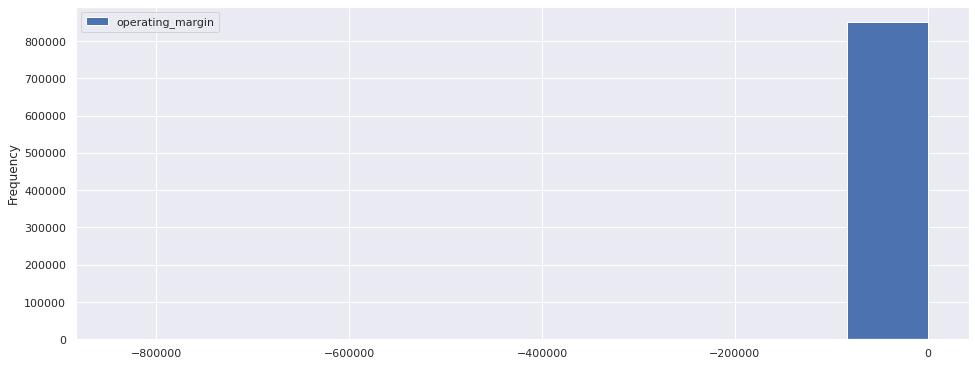

In [27]:
results.plot.hist();

The problem is that negative outliers (companies with extremely negative operating margins) are causing most values to be crammed in a single bin. We can fix this by using the `range` argument to `hist()` to zoom in on the bulk of the distribution. In addition, we'll increase the number of bins to 20, from the default 10.

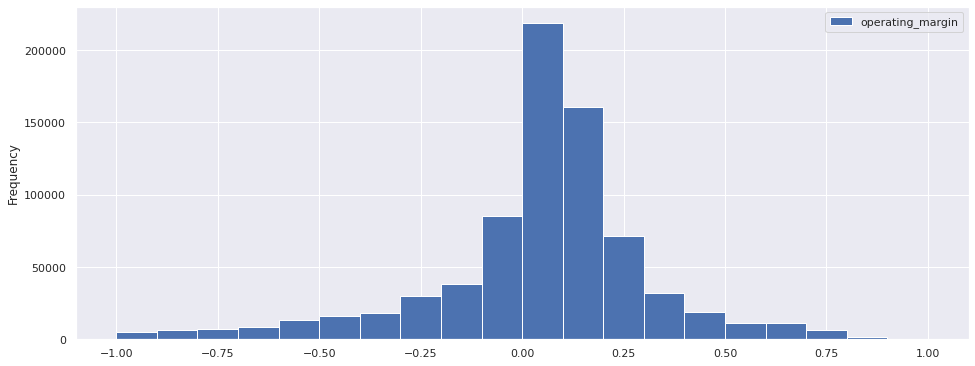

In [30]:
results.plot.hist(bins=20, range=(-1, 1));

## Clipping Outliers

Using `range` to zoom in on the distribution is useful for viewing the histogram, but it doesn't remove the outliers from the pipeline output itself. Before using the pipeline output in Alphalens or Zipline, perhaps it would be a good idea to adjust the pipeline to deal with the outliers. Beyond a certain point, increasingly negative operating margins don't provide useful additional information; it's enough to know that the company is very unprofitable. So, a reasonable solution is to clip the values to -1. This means that any values less than -1 will be replaced with -1. The Factor `clip()` method requires both a lower and upper bound. We'll set the upper bound to 1, knowing that since we already excluded companies with operating margins above 1, the upper bound is redundant. (The lower and upper bound can be set to `-np.inf` and `np.inf`, respectively, to indicate no bound.) 

In [32]:
pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin.clip(min_bound=-1, max_bound=1),
    },
    screen=BaseUniverse()
)

If we re-run the pipeline, we can now plot the histogram without using `range`. Notice that, unlike the previous histogram which ignored data outside the (-1, 1) range, in this histogram the clipped values cluster at -1. In other words, the previous histogram included a subset of the data, while this histogram includes all the data. 

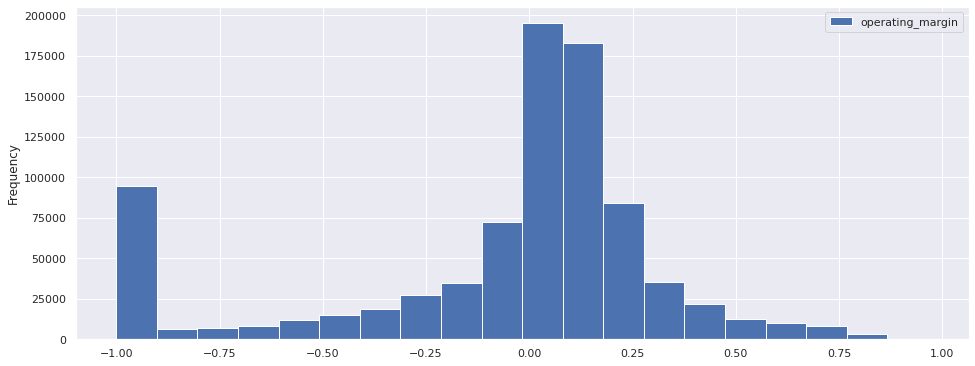

In [33]:
results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.plot.hist(bins=20);

> An alternative to using `clip()` to trim outliers is to use `winsorize()`. The difference between `clip()` and `winsorize()` is that `winsorize()` trims values above and below a certain percentile in the distribution, while `clip()` trims values above and below specific fixed values. 

***

## *Next Up*

Lesson 6: [Alphalens: Profitability](Lesson06-Profitability.ipynb)